## Importamos las librerías

In [1]:
import pandas as pd
import numpy as np

## Cargamos los datasets

In [2]:
X = pd.read_csv('../raw_data/X.csv', index_col = 0)
y = pd.read_csv('../raw_data/y.csv', index_col = 0)

print(X.shape)
print(y.shape)

(7500, 12115)
(7500, 5376)


In [3]:
y.columns

Index(['Q_AC_OFFICE_0', 'Q_AC_OFFICE_1', 'Q_AC_OFFICE_2', 'Q_AC_OFFICE_3',
       'Q_AC_OFFICE_4', 'Q_AC_OFFICE_5', 'Q_AC_OFFICE_6', 'Q_AC_OFFICE_7',
       'Q_AC_OFFICE_8', 'Q_AC_OFFICE_9',
       ...
       'T_INT_OFFICE_662', 'T_INT_OFFICE_663', 'T_INT_OFFICE_664',
       'T_INT_OFFICE_665', 'T_INT_OFFICE_666', 'T_INT_OFFICE_667',
       'T_INT_OFFICE_668', 'T_INT_OFFICE_669', 'T_INT_OFFICE_670',
       'T_INT_OFFICE_671'],
      dtype='object', length=5376)

In [4]:
columns_y = [x[:-4] for x in y.columns if '671' in x]
columns_y

['Q_AC_OFFICE',
 'Q_HEAT_OFFICE',
 'Q_PEOPLE',
 'Q_EQP',
 'Q_LIGHT',
 'Q_AHU_C',
 'Q_AHU_H',
 'T_INT_OFFICE']

In [5]:
# Coloco las variables de temperatura (T_INT_OFFICE) como features
cols_t = y.iloc[: , -672:]
X = pd.concat([X, cols_t], axis = 1)
y = y.iloc[: , :-672]

## Analizamos las variables que tenemos

In [6]:
columns_c = X.columns[0:19]
columns_c

Index(['airchange_infiltration_vol_per_h', 'capacitance_kJ_perdegreK_perm3',
       'power_VCV_kW_heat', 'power_VCV_kW_clim', 'nb_occupants', 'nb_PCs',
       'facade_1_thickness_2', 'facade_1_window_area_percent',
       'facade_2_thickness_2', 'facade_2_window_area_percent',
       'facade_3_thickness_2', 'facade_3_window_area_percent',
       'facade_4_thickness_2', 'facade_4_window_area_percent',
       'roof_thickness_2', 'ground_thickness_2', 'init_day', 'init_month',
       'init_year'],
      dtype='object')

In [7]:
columns_c = X.columns[0:16]

In [8]:
columns_s = [x[:-4] for x in X.columns if '671' in x]
columns_s

['ac_t_conf',
 'ac_t_red',
 'ac_mask',
 'heat_t_conf',
 'heat_t_red',
 'heat_mask',
 'ventilation_t',
 'ventilation_vol',
 'ventilation_mask',
 'occupancy',
 'pc_on_mask',
 'DNI',
 'IBEAM_H',
 'IBEAM_N',
 'IDIFF_H',
 'IGLOB_H',
 'RHUM',
 'TAMB',
 'T_INT_OFFICE']

In [9]:
columns_y = [x[:-4] for x in y.columns if '671' in x]
columns_y

['Q_AC_OFFICE',
 'Q_HEAT_OFFICE',
 'Q_PEOPLE',
 'Q_EQP',
 'Q_LIGHT',
 'Q_AHU_C',
 'Q_AHU_H']

## Escenario - Dataset con una fila para cada hora

### Cargamos los datasets (si ya están en el repositorio ir a última celda)

In [ ]:
X_tmp = X

X_per_h = None
for i in range(X_tmp.shape[0]):
    new_data_dict = {}
    for col in columns_s:
        columns_s_j = [f'{col}_{j}' for j in range(672)]
        new_data_dict[col] = X_tmp[columns_s_j].iloc[[i]].values[0].T
    new_df = pd.DataFrame(data = new_data_dict)
    for col in columns_c:
        new_df[col] = X_tmp.loc[i, col]
    if not(X_per_h is None):
        X_per_h = pd.concat([X_per_h, new_df])
        print(f'Se agregaron {i*672} filas de {X_tmp.shape[0]*672}')
    else:
        X_per_h = new_df

X_per_h.to_csv('../raw_data/X_per_h.csv')

In [ ]:
y_tmp = y

y_per_h = None
for i in range(y_tmp.shape[0]):
    new_data_dict = {}
    for col in columns_y:
        columns_y_j = [f'{col}_{j}' for j in range(672)]
        new_data_dict[col] = y_tmp[columns_y_j].iloc[[i]].values[0].T
    new_df = pd.DataFrame(data = new_data_dict)
  
    if not(y_per_h is None):
        y_per_h = pd.concat([y_per_h, new_df])
        print(f'Se agregaron {i*672} filas de {y_tmp.shape[0]*672}')
    else:
        y_per_h = new_df

y_per_h.to_csv('../raw_data/y_per_h.csv')

In [131]:
X_per_h = pd.read_csv('../raw_data/X_per_h.csv', index_col = 0)
y_per_h = pd.read_csv('../raw_data/y_per_h.csv', index_col = 0)

/home/davidp/.pyenv/versions/3.8.6/envs/modelo_energetico/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Analizamos la data

In [132]:
# Bajamos la cantidad de filas para no sobrepasar la RAM
data_per_h = pd.concat([X_per_h, y_per_h], axis = 1)
data_per_h = data_per_h.head(500_000)

X_per_h = data_per_h[X_per_h.columns]
y_per_h = data_per_h[y_per_h.columns]

In [133]:
y_per_h_total = y_per_h.sum(axis=1)
y_per_h_total

0      0.0000
1      1.6818
2      1.6818
3      1.6818
4      1.6818
       ...   
27     7.0426
28     7.0426
29     7.0426
30     7.0426
31    43.5240
Length: 500000, dtype: float64

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()
scaler.fit(X_per_h)
columns = X_per_h.columns

X_scaled = pd.DataFrame(scaler.transform(X_per_h), columns = columns)

sns.heatmap(pd.DataFrame(X_scaled).corr(), cmap='coolwarm');

In [ ]:
corr_cols= ['ac_mask',
 'ventilation_mask',
 'occupancy',
 'pc_on_mask',
 'DNI',
 'IBEAM_H',
 'IBEAM_N',
 'IDIFF_H',
 'IGLOB_H'
 ]
sns.heatmap(pd.DataFrame(X_per_h[corr_cols]).corr(), cmap='coolwarm');

Correlaciones relevantes:

*   pc_on_mask
*   occupancy
<br>

*   IBEAM_N
*   IGLOB_H
*   IBEAM_H
*   DNI

### Aplicamos PCA

In [ ]:
pca = PCA()
pca.fit(X_scaled)

In [ ]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 36)])

sns.heatmap(X_proj.corr(), cmap='coolwarm');

In [ ]:
pca.explained_variance_ratio_

In [17]:
import matplotlib.pyplot as plt

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [ ]:
# Reducimos la cantidad de componentes a 24
pca = PCA(n_components=24).fit(X_per_h)

X_proj24 = pd.DataFrame(pca.fit_transform(X_per_h), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24'])
X_proj24.head()

In [25]:
from sklearn.pipeline import Pipeline
from modelo_energetico.scaler import MultiScaler
from sklearn.linear_model import SGDRegressor

# Probamos con SGDRegressor en Gridsearch
pipe = Pipeline([
          ("scaling" , MultiScaler(scaler = "RobustScaler")),
        ("model", SGDRegressor())
])

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

params = {
    'scaling__scaler' : [StandardScaler(), RobustScaler(), MinMaxScaler() ],     
    'model__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'model__alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    'model__l1_ratio': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(pipe, 
                    param_grid= params, 
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    scoring = 'r2'
                   )

In [12]:
from datetime import datetime
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
      X_proj24, y_per_h_total, test_size=0.3, random_state=42)

grid.fit(X_train, y_train)
  
start = datetime.now()
best_estimator = grid.best_estimator_.fit(X_train, y_train)
stop = datetime.now()
score = best_estimator.score(X_test, y_test)
time = (stop - start).seconds

In [ ]:
(score, time)

r2 = 0.704 \
tiempo = 4 seg

In [ ]:
# Agregamos columna con consumo en hora anterior
y_per_h_total.head()

In [ ]:
y_per_h_total_offset = y_per_h_total.shift(periods= 1, fill_value= 0)
y_per_h_total_offset.head()

In [ ]:
X_per_h['Prev_Q'] = y_per_h_total_offset
X_per_h.head()

In [ ]:
X_scaled.shape

In [ ]:
# Aplicamos PCA nuevamente
scaler.fit(X_per_h)
columns = X_per_h.columns
X_scaled = pd.DataFrame(scaler.transform(X_per_h), columns = columns)

pca = PCA()
pca.fit(X_scaled)

X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 37)])

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [ ]:
pca.explained_variance_ratio_

In [ ]:
# Reducimos la cantidad de componentes a 28
pca = PCA(n_components=28).fit(X_per_h)

X_proj28 = pd.DataFrame(pca.fit_transform(X_per_h), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28'])
X_proj28.head()

In [ ]:
# Probamos nuevamente el SGDRegressor
pipe = Pipeline([
          ("scaling" , MultiScaler(scaler = "RobustScaler")),
        ("model", SGDRegressor())
])

In [ ]:
params = {
    'scaling__scaler' : [StandardScaler(), RobustScaler(), MinMaxScaler() ],     
    'model__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'model__alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    'model__l1_ratio': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(pipe, 
                    param_grid= params, 
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    scoring = 'r2'
                   )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
      X_proj28, y_per_h_total, test_size=0.3, random_state=42)

grid.fit(X_train, y_train)
  
start = datetime.now()
best_estimator = grid.best_estimator_.fit(X_train, y_train)
stop = datetime.now()
score = best_estimator.score(X_test, y_test)
time = (stop - start).seconds

In [ ]:
(score, time)

r2 = 0.707 \
tiempo = 5 seg

## Escenario - Dataset con rangos de tiempo por fila

### Armamos datasets para distintos períodos

In [10]:
from modelo_energetico.col_reductor import total_q_hour

# El Target (Q) lo trabajamos sumando todos los tipos (Q global)
y = total_q_hour(y)
y.head()

/home/davidp/code/rcister01/modelo_energetico/modelo_energetico/col_reductor.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dataframe[f'Q_{i}'] = np.zeros(dataframe.shape[0])


,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,...,Q_662,Q_663,Q_664,Q_665,Q_666,Q_667,Q_668,Q_669,Q_670,Q_671
0,0.0,1.6818,1.6818,1.6818,1.6818,1.6818,1.6818,35.4240,38.7781,38.7781,...,88.8217,95.9126,102.8931,102.8037,48.4459,12.9279,1.6818,5.1005,11.4541,8.6840
1,0.0,2.9261,2.9261,2.9261,2.9261,2.9261,2.9261,44.8740,44.8740,44.8740,...,23.4454,21.4724,22.6562,23.8400,2.9261,2.9261,2.9261,2.9261,2.9261,2.9261
2,0.0,3.6095,3.6095,3.6095,3.6095,3.6095,3.6095,95.0924,92.1329,87.3977,...,78.1176,77.4426,79.1440,82.4168,84.3485,13.3174,3.6095,3.6095,3.6095,3.6095
3,0.0,7.2196,7.2196,7.2196,7.2196,7.2196,7.2196,50.6268,49.7390,48.2592,...,52.7971,52.4025,52.0079,52.4025,52.7971,7.2196,7.2196,7.2196,7.2196,7.2196
4,0.0,6.4811,6.4811,6.4811,6.4811,6.4811,6.4811,6.4811,6.4811,10.2298,...,70.2297,74.8921,78.2945,78.5638,6.4811,6.4811,13.5212,30.9471,25.7187,12.1803


In [13]:
from modelo_energetico.col_reductor import reduce_columns_period_avg, reduce_columns_period_sum

X_reduced_train = {}
y_reduced_train = {}
X_reduced_test = {}
y_reduced_test = {}

for div in [1, 2, 4, 7, 14, 28]:
    X_reduced = pd.concat([X[columns_c], reduce_columns_period_avg(X, columns_s, div)], axis = 1)
    y_reduced = reduce_columns_period_sum(y, ['Q'], div)

    X_reduced_train[div], X_reduced_test[div], y_reduced_train[div], y_reduced_test[div] = train_test_split(X_reduced, y_reduced, test_size=0.3, random_state=42)

/home/davidp/code/rcister01/modelo_energetico/modelo_energetico/col_reductor.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dataframe[f'{column}_{i}'] = np.zeros(dataframe.shape[0])


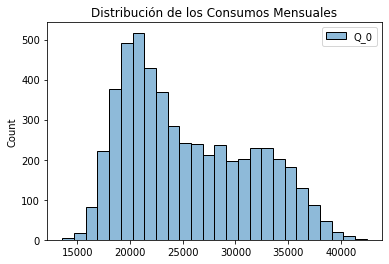

In [18]:
sns.histplot(data=y_reduced_train[28])
plt.title('Distribución de los Consumos Mensuales');

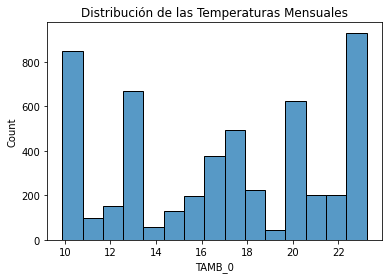

In [19]:
sns.histplot(data=X_reduced_train[28]['TAMB_0'])
plt.title('Distribución de las Temperaturas Mensuales');

In [20]:
X_reduced_train[28]['TAMB_0'].describe()

count    5250.000000
mean       16.899128
std         4.482166
min         9.890476
25%        12.704315
50%        17.136756
75%        20.713839
max        23.247024
Name: TAMB_0, dtype: float64

In [21]:
y_reduced_train[28]['T_level'] = X_reduced_train[28]['TAMB_0'].apply(lambda x: 0 if x < 12.636607 else (1 if x < 17.136756 else (2 if x < 20.713839 else 3)))
y_reduced_train[28].head()

,Q_0,T_level
7179,29650.1766,2
6054,30924.1840,2
7269,25277.1535,1
4866,22236.5015,2
3593,31469.5410,3


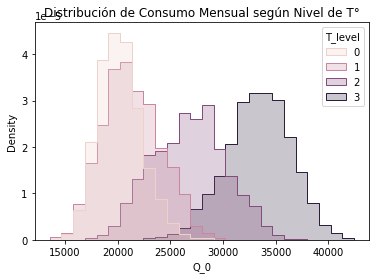

In [22]:
plt.title('Distribución de Consumo Mensual según Nivel de T°')
sns.histplot(data=y_reduced_train[28], x="Q_0", hue="T_level", stat= 'density', element='step');

### Probamos SGDRegressor con distintos períodos

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

pipe = Pipeline([
          ("scaling" , MultiScaler(scaler = "RobustScaler")),
        ("model", MultiOutputRegressor(estimator = SGDRegressor()))
])

In [ ]:
for i in pipe.get_params().keys():
    print(i)

In [ ]:
params = {
    'scaling__scaler' : [StandardScaler(), RobustScaler(), MinMaxScaler() ],     
    'model__estimator__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'model__estimator__alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    'model__estimator__l1_ratio': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(pipe, 
                    param_grid= params, 
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    scoring = 'r2'
                   )

In [ ]:
models = {}
results = {}

for div in [28, 14, 7]:
    grid.fit(X_reduced_train[div], y_reduced_train[div])
  
    start = datetime.now()
    best_estimator = grid.best_estimator_.fit(X_reduced_train[div], y_reduced_train[div])
    stop = datetime.now()
    
    best_score = best_estimator.score(X_reduced_test[div], y_reduced_test[div])
    time = (stop - start).seconds
  
    models[div] = best_estimator
    results[div] = (best_score, time)

7 days --> r2= 0.9475 (0 secs): \
1.   alpha= 0.0001
2.   l1_ratio= 0.01
3.   loss= squared_epsilon_insensitive \

14 days --> r2= 0.9527 (0 secs): \
1.   alpha= 0.0001
2.   l1_ratio= 0.1
3.   loss= squared_epsilon_insensitive

28 days --> r2= 0.9620 (0 secs): \
1.   alpha= 0.0001
2.   l1_ratio= 0.1
3.   loss= squared_epsilon_insensitive

In [ ]:
# Probamos con 28 días de rango
pipe = Pipeline([
          ("scaling" , StandardScaler()),
        ("model", MultiOutputRegressor(estimator = SGDRegressor()))
])

start = datetime.now()
model = pipe.fit(X_reduced_train[1], y_reduced_train[1])
stop = datetime.now()

time = (stop - start).seconds

In [ ]:
model.score(X_reduced_test[1], y_reduced_test[1])

1 day --> r2= 0.9346 (7 secs): \
1.   alpha= 0.0001
2.   l1_ratio= 0.15
3.   loss= squared_loss

## Redes neuronales

### Escenario - Dataset con rangos de tiempo por fila

In [115]:
# Probamos sobre el escenario de consumo mensual (período de 28 días)
scaler = StandardScaler()
scaler.fit(X_reduced_train[28])
X_train_scaled = scaler.transform(X_reduced_train[28])
X_test_scaled = scaler.transform(X_reduced_test[28])

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_vanilla_nn(n_neurons, input_dim, output_dim):
    model = Sequential()
    model.add(layers.Dense(n_neurons[0], activation='relu', input_dim=input_dim))
    for i in range(1, len(n_neurons)):
        model.add(layers.Dense(n_neurons[i], activation='relu'))
    model.add(layers.Dense(output_dim, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

    return model

In [117]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

input_dim = X_train_scaled.shape[1]
output_dim = y_reduced_train[28].shape[1]
nn = (150, 100, 50, 50, 25, 10)

model = KerasRegressor(init_vanilla_nn, n_neurons=nn, input_dim=input_dim, output_dim=output_dim)

In [119]:
history = model.fit(X_train_scaled, y_reduced_train[28],
          validation_data=(X_test_scaled, y_reduced_test[28]), 
          batch_size=16,
          epochs=1000)

Epoch 1/1000
329/329 [==============================] - 1s 3ms/step - loss: 100602440.0000 - mae: 5251.7266 - val_loss: 346669952.0000 - val_mae: 13827.3945
Epoch 2/1000
329/329 [==============================] - 1s 2ms/step - loss: 2407234.7500 - mae: 874.2605 - val_loss: 345245504.0000 - val_mae: 13555.5605
Epoch 3/1000
329/329 [==============================] - 1s 2ms/step - loss: 1628535.5000 - mae: 719.4095 - val_loss: 344781600.0000 - val_mae: 13463.8252
Epoch 4/1000
329/329 [==============================] - 1s 2ms/step - loss: 1225825.5000 - mae: 625.0781 - val_loss: 344496544.0000 - val_mae: 13386.5186
Epoch 5/1000
329/329 [==============================] - 1s 2ms/step - loss: 980986.8125 - mae: 560.5739 - val_loss: 344316160.0000 - val_mae: 13341.1270
Epoch 6/1000
329/329 [==============================] - 1s 3ms/step - loss: 814113.8125 - mae: 507.8325 - val_loss: 344051840.0000 - val_mae: 13300.1982
Epoch 7/1000
329/329 [==============================] - 1s 3ms/step - loss:

Epoch 54/1000
329/329 [==============================] - 1s 2ms/step - loss: 192106.7656 - mae: 254.2507 - val_loss: 343697600.0000 - val_mae: 13067.9268
Epoch 55/1000
329/329 [==============================] - 1s 2ms/step - loss: 190569.4844 - mae: 254.2661 - val_loss: 342978624.0000 - val_mae: 13148.5889
Epoch 56/1000
329/329 [==============================] - 1s 2ms/step - loss: 209058.2969 - mae: 267.2036 - val_loss: 343076640.0000 - val_mae: 13059.3008
Epoch 57/1000
329/329 [==============================] - 1s 2ms/step - loss: 182749.0312 - mae: 248.8031 - val_loss: 343420864.0000 - val_mae: 13124.2451
Epoch 58/1000
329/329 [==============================] - 1s 2ms/step - loss: 206966.9062 - mae: 266.6868 - val_loss: 343291424.0000 - val_mae: 13072.0264
Epoch 59/1000
329/329 [==============================] - 1s 2ms/step - loss: 184114.8438 - mae: 250.4852 - val_loss: 343603104.0000 - val_mae: 13061.9238
Epoch 60/1000
329/329 [==============================] - 1s 2ms/step - loss:

KeyboardInterrupt: 

In [120]:
def init_vanilla_nn_w_dropout(n_neurons, input_dim, output_dim):
    model = Sequential()
    model.add(layers.Dense(n_neurons[0], activation='relu', input_dim=input_dim))
    model.add(layers.Dropout(.2))
    for i in range(1, len(n_neurons)):
        model.add(layers.Dense(n_neurons[i], activation='relu'))
    model.add(layers.Dense(output_dim, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

    return model

In [113]:
model = KerasRegressor(init_vanilla_nn_w_dropout, n_neurons=nn, input_dim=input_dim, output_dim=output_dim)

In [121]:
history = model.fit(X_train_scaled, y_reduced_train[28],
          validation_data=(X_test_scaled, y_reduced_test[28]), 
          batch_size=16,
          epochs=1000)

Epoch 1/1000
329/329 [==============================] - 1s 3ms/step - loss: 94739792.0000 - mae: 4634.9253 - val_loss: 347037248.0000 - val_mae: 13880.3525
Epoch 2/1000
329/329 [==============================] - 1s 2ms/step - loss: 2520939.7500 - mae: 890.8455 - val_loss: 345414784.0000 - val_mae: 13598.2949
Epoch 3/1000
329/329 [==============================] - 1s 2ms/step - loss: 1723432.7500 - mae: 737.9659 - val_loss: 344980224.0000 - val_mae: 13508.7148
Epoch 4/1000
329/329 [==============================] - 1s 2ms/step - loss: 1341169.2500 - mae: 649.5721 - val_loss: 344688384.0000 - val_mae: 13407.2334
Epoch 5/1000
329/329 [==============================] - 1s 2ms/step - loss: 1074711.5000 - mae: 583.0770 - val_loss: 344517792.0000 - val_mae: 13395.5234
Epoch 6/1000
329/329 [==============================] - 1s 2ms/step - loss: 895586.3125 - mae: 535.3611 - val_loss: 344210048.0000 - val_mae: 13312.2334
Epoch 7/1000
329/329 [==============================] - 1s 2ms/step - loss:

Epoch 54/1000
329/329 [==============================] - 1s 2ms/step - loss: 171750.3750 - mae: 235.4542 - val_loss: 343449408.0000 - val_mae: 13096.2188
Epoch 55/1000
329/329 [==============================] - 1s 2ms/step - loss: 183762.1562 - mae: 243.1798 - val_loss: 343676352.0000 - val_mae: 13080.0664
Epoch 56/1000
329/329 [==============================] - 1s 3ms/step - loss: 188210.3281 - mae: 245.7271 - val_loss: 343548384.0000 - val_mae: 13113.4326
Epoch 57/1000
329/329 [==============================] - 1s 2ms/step - loss: 170247.0781 - mae: 233.9823 - val_loss: 343549664.0000 - val_mae: 13101.6914
Epoch 58/1000
329/329 [==============================] - 1s 2ms/step - loss: 174750.5156 - mae: 236.8162 - val_loss: 343530784.0000 - val_mae: 13087.6699
Epoch 59/1000
329/329 [==============================] - 1s 2ms/step - loss: 183230.8906 - mae: 241.4745 - val_loss: 343452224.0000 - val_mae: 13079.8838
Epoch 60/1000
329/329 [==============================] - 1s 2ms/step - loss:

KeyboardInterrupt: 

In [125]:
from tensorflow.keras import regularizers

reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

def init_vanilla_nn_w_reg(n_neurons, input_dim, output_dim):
    model = Sequential()
    model.add(layers.Dense(n_neurons[0], activation='relu', input_dim=input_dim))
    model.add(layers.Dense(n_neurons[1], activation='relu', kernel_regularizer=reg_l1_l2))
    for i in range(2, len(n_neurons)):
        model.add(layers.Dense(n_neurons[i], activation='relu'))
    model.add(layers.Dense(output_dim, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

    return model

In [126]:
model = KerasRegressor(init_vanilla_nn_w_reg, n_neurons=nn, input_dim=input_dim, output_dim=output_dim)

In [127]:
history = model.fit(X_train_scaled, y_reduced_train[28],
          validation_data=(X_test_scaled, y_reduced_test[28]), 
          batch_size=16,
          epochs=1000)

Epoch 1/1000
329/329 [==============================] - 1s 3ms/step - loss: 90959120.0000 - mae: 4476.0298 - mse: 90959120.0000 - val_loss: 346538208.0000 - val_mae: 13807.5576 - val_mse: 346538208.0000
Epoch 2/1000
329/329 [==============================] - 1s 3ms/step - loss: 2441302.2500 - mae: 876.9330 - mse: 2441292.7500 - val_loss: 345351488.0000 - val_mae: 13579.3652 - val_mse: 345351488.0000
Epoch 3/1000
329/329 [==============================] - 1s 3ms/step - loss: 1662755.3750 - mae: 722.6714 - mse: 1662745.8750 - val_loss: 344935552.0000 - val_mae: 13498.1631 - val_mse: 344935552.0000
Epoch 4/1000
329/329 [==============================] - 1s 2ms/step - loss: 1317022.6250 - mae: 644.5860 - mse: 1317013.3750 - val_loss: 344537856.0000 - val_mae: 13411.1104 - val_mse: 344537856.0000
Epoch 5/1000
329/329 [==============================] - 1s 2ms/step - loss: 1072220.3750 - mae: 585.2071 - mse: 1072210.1250 - val_loss: 344375136.0000 - val_mae: 13363.3682 - val_mse: 344375136.00

329/329 [==============================] - 1s 2ms/step - loss: 211484.7656 - mae: 260.4957 - mse: 211475.1875 - val_loss: 343433728.0000 - val_mae: 13105.7168 - val_mse: 343433728.0000
Epoch 43/1000
329/329 [==============================] - 1s 2ms/step - loss: 200990.9219 - mae: 253.8279 - mse: 200981.5469 - val_loss: 343384352.0000 - val_mae: 13071.5420 - val_mse: 343384352.0000
Epoch 44/1000
329/329 [==============================] - 1s 3ms/step - loss: 202420.5469 - mae: 256.5647 - mse: 202410.9531 - val_loss: 343506816.0000 - val_mae: 13093.5068 - val_mse: 343506816.0000
Epoch 45/1000
329/329 [==============================] - 1s 3ms/step - loss: 213205.6719 - mae: 262.7970 - mse: 213196.0938 - val_loss: 343484640.0000 - val_mae: 13111.1055 - val_mse: 343484640.0000
Epoch 46/1000
329/329 [==============================] - 1s 2ms/step - loss: 206890.2031 - mae: 257.6681 - mse: 206880.7656 - val_loss: 343569856.0000 - val_mae: 13138.2393 - val_mse: 343569856.0000
Epoch 47/1000
329/3

329/329 [==============================] - 1s 2ms/step - loss: 158034.4688 - mae: 224.5312 - mse: 158024.7344 - val_loss: 343491936.0000 - val_mae: 13066.2559 - val_mse: 343491936.0000
Epoch 84/1000
329/329 [==============================] - 1s 2ms/step - loss: 155166.5781 - mae: 222.0206 - mse: 155156.8438 - val_loss: 343405248.0000 - val_mae: 13064.1572 - val_mse: 343405248.0000
Epoch 85/1000
329/329 [==============================] - 1s 3ms/step - loss: 153318.2344 - mae: 221.2574 - mse: 153308.5156 - val_loss: 343399168.0000 - val_mae: 13073.8799 - val_mse: 343399168.0000
Epoch 86/1000
329/329 [==============================] - 1s 3ms/step - loss: 147088.5000 - mae: 217.4721 - mse: 147078.6875 - val_loss: 343458208.0000 - val_mae: 13076.5264 - val_mse: 343458208.0000
Epoch 87/1000
329/329 [==============================] - 1s 3ms/step - loss: 151426.8750 - mae: 219.6242 - mse: 151417.1562 - val_loss: 343435840.0000 - val_mae: 13064.3691 - val_mse: 343435840.0000
Epoch 88/1000
329/3

KeyboardInterrupt: 

In [128]:
# Probamos una red más simple

nn = (60, 25, 25, 10) #Anterior (150, 100, 50, 50, 25, 10)

model = KerasRegressor(init_vanilla_nn, n_neurons=nn, input_dim=input_dim, output_dim=output_dim)

In [129]:
history = model.fit(X_train_scaled, y_reduced_train[28],
          validation_data=(X_test_scaled, y_reduced_test[28]), 
          batch_size=16,
          epochs=1000)

Epoch 1/1000
329/329 [==============================] - 1s 2ms/step - loss: 247990176.0000 - mae: 10355.7773 - val_loss: 379875040.0000 - val_mae: 16530.5176
Epoch 2/1000
329/329 [==============================] - 1s 2ms/step - loss: 17389138.0000 - mae: 2513.7275 - val_loss: 351604768.0000 - val_mae: 14524.2139
Epoch 3/1000
329/329 [==============================] - 1s 2ms/step - loss: 5229878.0000 - mae: 1354.8046 - val_loss: 346843360.0000 - val_mae: 13885.7480
Epoch 4/1000
329/329 [==============================] - 1s 2ms/step - loss: 2669767.7500 - mae: 939.0933 - val_loss: 345364768.0000 - val_mae: 13624.1523
Epoch 5/1000
329/329 [==============================] - 1s 2ms/step - loss: 1856584.7500 - mae: 768.1232 - val_loss: 344848768.0000 - val_mae: 13507.4307
Epoch 6/1000
329/329 [==============================] - 1s 2ms/step - loss: 1483974.1250 - mae: 681.9594 - val_loss: 344752864.0000 - val_mae: 13448.1631
Epoch 7/1000
329/329 [==============================] - 1s 2ms/step -

329/329 [==============================] - 1s 2ms/step - loss: 219329.2969 - mae: 267.0456 - val_loss: 343385408.0000 - val_mae: 13068.6104
Epoch 55/1000
329/329 [==============================] - 1s 2ms/step - loss: 214636.2969 - mae: 263.3524 - val_loss: 343451808.0000 - val_mae: 13067.6611
Epoch 56/1000
329/329 [==============================] - 1s 2ms/step - loss: 218146.0781 - mae: 266.5094 - val_loss: 343397952.0000 - val_mae: 13071.8350
Epoch 57/1000
329/329 [==============================] - 1s 2ms/step - loss: 213520.0469 - mae: 262.8047 - val_loss: 343448480.0000 - val_mae: 13068.3955
Epoch 58/1000
329/329 [==============================] - 1s 2ms/step - loss: 211851.7969 - mae: 262.0847 - val_loss: 343577824.0000 - val_mae: 13083.8457
Epoch 59/1000
329/329 [==============================] - 1s 2ms/step - loss: 217800.2344 - mae: 264.2344 - val_loss: 343538080.0000 - val_mae: 13076.6045
Epoch 60/1000
329/329 [==============================] - 1s 2ms/step - loss: 207576.6719 -

329/329 [==============================] - 1s 2ms/step - loss: 180775.5469 - mae: 241.9735 - val_loss: 343403008.0000 - val_mae: 13057.4277
Epoch 108/1000
329/329 [==============================] - 1s 2ms/step - loss: 174873.2656 - mae: 239.6587 - val_loss: 343513216.0000 - val_mae: 13054.9541
Epoch 109/1000
329/329 [==============================] - 1s 2ms/step - loss: 177906.5000 - mae: 239.9822 - val_loss: 343470144.0000 - val_mae: 13075.3135
Epoch 110/1000
329/329 [==============================] - 1s 2ms/step - loss: 177237.1250 - mae: 240.8434 - val_loss: 343366688.0000 - val_mae: 13064.2256
Epoch 111/1000
329/329 [==============================] - 1s 2ms/step - loss: 175328.9062 - mae: 239.4029 - val_loss: 343471520.0000 - val_mae: 13053.9111
Epoch 112/1000
329/329 [==============================] - 1s 2ms/step - loss: 178324.0156 - mae: 241.1885 - val_loss: 343384800.0000 - val_mae: 13051.7178
Epoch 113/1000
329/329 [==============================] - 1s 2ms/step - loss: 174213.

KeyboardInterrupt: 

### Escenario - Dataset con hora por fila

In [151]:
data_per_h = pd.concat([X_per_h, y_per_h], axis = 1)
data_per_h = data_per_h.head(100_000)

X_per_h = data_per_h[X_per_h.columns]
y_per_h = data_per_h[y_per_h.columns]

In [153]:
y_per_h.shape

(100000, 7)

In [154]:
scaler = StandardScaler()
scaler.fit(X_per_h)
columns = X_per_h.columns

X_scaled = pd.DataFrame(scaler.transform(X_per_h), columns = columns)

In [155]:
y_per_h_total = y_per_h.sum(axis=1)
y_per_h_total

0       0.0000
1       1.6818
2       1.6818
3       1.6818
4       1.6818
        ...   
539    74.1547
540    75.8138
541    81.2446
542    83.6257
543    89.8895
Length: 100000, dtype: float64

In [156]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y_per_h_total, test_size=0.3, random_state=42)

In [157]:
input_dim = X_scaled_train.shape[1]
output_dim = y_train.shape[0]
nn = (50, 25, 10)

model = KerasRegressor(init_vanilla_nn, n_neurons=nn, input_dim=input_dim, output_dim=output_dim)

In [158]:
history = model.fit(X_scaled_train, y_train,
          validation_data=(X_scaled_test, y_test), 
          batch_size=32,
          epochs=100)

Epoch 1/100
2188/2188 [==============================] - 72s 33ms/step - loss: 526.3610 - mae: 13.2892 - val_loss: 339.0059 - val_mae: 10.9425
Epoch 2/100
2188/2188 [==============================] - 73s 33ms/step - loss: 317.2792 - mae: 10.0326 - val_loss: 285.9495 - val_mae: 9.3823
Epoch 3/100
2188/2188 [==============================] - 73s 33ms/step - loss: 280.6532 - mae: 9.0228 - val_loss: 260.1825 - val_mae: 8.3852
Epoch 4/100
2188/2188 [==============================] - 74s 34ms/step - loss: 259.5383 - mae: 8.4847 - val_loss: 245.6789 - val_mae: 8.2110
Epoch 5/100
2188/2188 [==============================] - 77s 35ms/step - loss: 244.6443 - mae: 8.1083 - val_loss: 235.6538 - val_mae: 7.9944
Epoch 6/100
2188/2188 [==============================] - 68s 31ms/step - loss: 233.7692 - mae: 7.8227 - val_loss: 224.6614 - val_mae: 7.4497
Epoch 7/100
2188/2188 [==============================] - 74s 34ms/step - loss: 226.4243 - mae: 7.6412 - val_loss: 224.9382 - val_mae: 7.5125
Epoch 8/10

KeyboardInterrupt: 